In [592]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [477]:
# Import dataset
events = pd.read_excel('~/Downloads/combined_events.xlsx')
events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,A Communist Party of India-Maoist (CPI-Maoist)...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,Communist Party of India-Maoist (CPI-Maoist) m...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,Senior separatist leaders Syed Ali Shah Geelan...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Opposing Government of Indias (GoI) reported d...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Cadres of the Communist Party of India-Maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


In [478]:
events.shape

(1084, 16)

In [479]:
events.describe()

,relevant_event,multiple_events,internal_conflict,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism
count,1084.000000,815.000000,812.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,343.000000
mean,0.677122,0.100613,0.945813,3.810458,0.098039,0.050654,0.155229,0.044118,0.016340,0.331699,0.068627,0.093294
std,0.467792,0.301001,0.226526,57.089501,0.297611,0.219469,0.362419,0.205524,0.126883,0.471209,0.253026,0.291270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preprocessing

In [480]:
# Function for processing text
def nlp_pipeline(data):
    # Convert to lower case
    data['description'] = data['description'].str.lower()
    # Remove duplicate values
    data = data.drop_duplicates().reset_index(drop=True)
    row_lst = []
    lem = WordNetLemmatizer()
    stop = stopwords.words('english')
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        # Remove non-alphanumeric characters
        row = re.sub(r'[^0-9A-Za-z]',  ' ', row)
        # Remove stopwords and lemmatizing
        row = ' '.join([lem.lemmatize(word) for word in row.split() if not word in set(stopwords.words('english'))])
        row_lst.append(row)
    data['description'] = row_lst
    return data

# Function for removing additional words
def remove_words(data, words_to_remove):
    row_lst = []
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        for word in words_to_remove:
            row = re.sub(word, '', row)
        row_lst.append(row)
    data['description'] = row_lst
    return data

In [481]:
# Clean data
cleaned_events = nlp_pipeline(events)
cleaned_events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,communist party india maoist cpi maoist comman...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,communist party india maoist cpi maoist militi...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,senior separatist leader syed ali shah geelani...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,opposing government india goi reported decisio...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,cadre communist party india maoist cpi maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


## Support Vector Machine for `relevant_event`

### Cross-Validation

#### 1. Number of Features

First, I'm doing cross-validation to identify the optimal number of features to use in the model.

In [699]:
# Define function for cross-validation
def cross_validation(kernel, C, gamma, num_features, folds):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    SVM = svm.SVC(C=C, kernel=kernel, degree=3, gamma=gamma)
    vectorizer_tf = TfidfVectorizer(max_features=num_features)
    encoder = LabelEncoder()
    X = vectorizer_tf.fit_transform(cleaned_events['description']).toarray()
    X_scaled = preprocessing.scale(X)
    Y = encoder.fit_transform(cleaned_events['relevant_event'])
    for train_idx, valid_idx in kf.split(X):
        split_X_train, split_X_valid = X_scaled[train_idx, :], X_scaled[valid_idx, :]
        split_Y_train, split_Y_valid = Y[train_idx], Y[valid_idx]
        SVM.fit(split_X_train,split_Y_train)
        predictions_SVM = SVM.predict(split_X_valid)
        accuracy.append(accuracy_score(predictions_SVM, split_Y_valid))
    return np.mean(accuracy)

In [685]:
# Perform cross-validation based on the number of features and folds - takes extremely long to run! 
# Change interval (currently 10) to shorten runtime
num_features = np.array(range(1, 3001, 10))
folds = np.array(range(2, 6))
accuracy_cv = pd.DataFrame(columns = ['number of features', 'folds', 'accuracy'])

for n in num_features:
    for f in folds:
        accuracy_cv = accuracy_cv.append({'number of features': n, 'folds': f, 'accuracy': cross_validation('linear', 1, 'auto' n, f)}, ignore_index=True)

In [686]:
# Create table to display results of CV
accuracy_cv['number of features'] = accuracy_cv['number of features'].astype('int')
accuracy_cv['folds'] = accuracy_cv['folds'].astype('int')

accuracy_cv.head(5)

,number of features,folds,accuracy
0,1,2,0.679945
1,1,3,0.679953
2,1,4,0.679945
3,1,5,0.679821
4,11,2,0.774725


In [687]:
# Accuracy based on the number of features
grouped_features = accuracy_cv.groupby('number of features')[['accuracy']].mean().sort_values(by='accuracy', ascending=False).reset_index()
grouped_features

,number of features,accuracy
0,31,0.800130
1,111,0.788453
2,81,0.786762
3,21,0.786422
4,41,0.786054
...,...,...
295,2751,0.718065
296,2941,0.717340
297,2831,0.714315
298,2861,0.712261


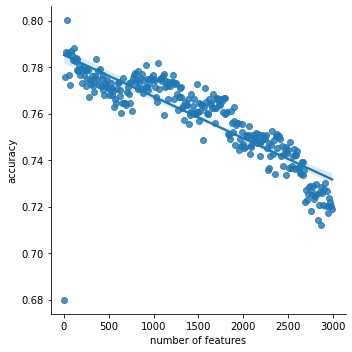

In [688]:
# Plot accuracy vs. number of features
sns.lmplot(x='number of features', y='accuracy', data=grouped_features)
plt.show()

#### 2. Kernel type

Next, I'm repeating the cross-validation using the RBF kernel (as opposed to the linear kernel used in the previous section).

In [700]:
# Perform cross-validation based on the number of features and folds - takes extremely long to run! 
# Change interval (currently 10) to shorten runtime
num_features = np.array(range(1, 3001, 10))
folds = np.array(range(2, 6))
accuracy_cv = pd.DataFrame(columns = ['number of features', 'folds', 'accuracy'])

for n in num_features:
    for f in folds:
        accuracy_cv = accuracy_cv.append({'number of features': n, 'folds': f, 'accuracy': cross_validation('rbf', 1, 'auto', n, f)}, ignore_index=True)

In [701]:
# Create table to display results of CV
accuracy_cv['number of features'] = accuracy_cv['number of features'].astype('int')
accuracy_cv['folds'] = accuracy_cv['folds'].astype('int')

,number of features,folds,accuracy
0,1,2,0.679945
1,1,3,0.679965
2,1,4,0.679945
3,1,5,0.679943
4,11,2,0.787088


In [702]:
# Accuracy based on the number of features
grouped_features = accuracy_cv.groupby('number of features')[['accuracy']].mean().sort_values(by='accuracy', ascending=False).reset_index()
grouped_features

,number of features,accuracy
0,31,0.799441
1,111,0.790536
2,51,0.790503
3,41,0.790200
4,121,0.788469
...,...,...
295,2741,0.719416
296,2921,0.717031
297,2821,0.714300
298,2931,0.710839


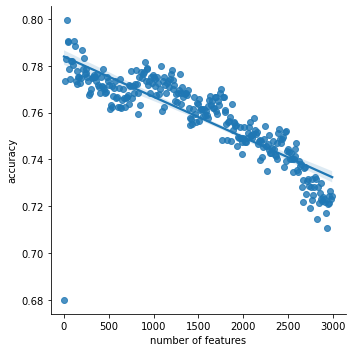

In [707]:
# Plot accuracy vs. number of features
sns.lmplot(x='number of features', y='accuracy', data=grouped_features)
plt.show()

## Training 

Train the model and compute the testing accuracy using the hyperparameters found using cross-validation.

In [746]:
# Vectorize the data using TFIDF
vectorizer_tf = TfidfVectorizer(max_features=31)
tf = vectorizer_tf.fit_transform(cleaned_events['description'])
tf_scaled = preprocessing.scale(tf.toarray())

In [743]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tf_scaled, cleaned_events['relevant_event'], test_size=0.25, random_state=42)

In [744]:
# Label encoding - transform the outcome variable to a suitable format for classification
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [745]:
# Train the SVM model and use it for prediction
SVM = svm.SVC(C=1, kernel='rbf', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print("Test accuracy:", accuracy_score(predictions_SVM, y_test)*100)

Test accuracy: 84.61538461538461


----